In [10]:
import sqlite3
import pandas as pd
import openai

In [9]:
def get_summary_info(db_path):
  """
  This function connects to a SQLite database and retrieves summary information about the Fires table.

  Args:
      db_path (str): Path to the SQLite database file.

  Returns:
      dict: A dictionary containing summary information about the Fires table.
  """

  # Connect to the database
  conn = sqlite3.connect(db_path)

  # Get basic statistics
  summary_info = {}
  cursor = conn.cursor()

  # Get number of rows (total fires)
  cursor.execute("SELECT COUNT(*) FROM Fires")
  total_fires, = cursor.fetchone()
  summary_info["Total Fires"] = total_fires

  # Get earliest and latest fire years
  cursor.execute("SELECT MIN(FIRE_YEAR), MAX(FIRE_YEAR) FROM Fires")
  min_year, max_year = cursor.fetchone()
  summary_info["Year Range"] = f"{min_year} - {max_year}"

  # Get average fire size
  cursor.execute("SELECT AVG(FIRE_SIZE) FROM Fires")
  avg_fire_size, = cursor.fetchone()
  summary_info["Average Fire Size (acres)"] = f"{avg_fire_size:.2f}"

  # Get most frequent fire cause description (assuming a STAT_CAUSE_DESCR column)
  cursor.execute("SELECT STAT_CAUSE_DESCR, COUNT(*) AS count FROM Fires GROUP BY STAT_CAUSE_DESCR ORDER BY count DESC LIMIT 1")
  most_frequent_cause, count = cursor.fetchone()
  summary_info["Most Frequent Cause"] = f"{most_frequent_cause} ({count} fires)"

  # Close the connection
  conn.close()

  return summary_info

summary_info = get_summary_info("archive/wildfires.sqlite")

# Print the summary information
for key, value in summary_info.items():
  print(f"{key}: {value}")


Total Fires: 1880465
Year Range: 1992 - 2015
Average Fire Size (acres): 74.52
Most Frequent Cause: Debris Burning (429028 fires)


In [11]:
conn = sqlite3.connect('archive/wildfires.sqlite')
df = pd.read_sql_query("SELECT * FROM fires", conn)

In [13]:
df.columns

Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'Shape'],
      dtype='object')

In [51]:
# from langchain.agents import create_pandas_dataframe_agent
from langchain_experimental.agents import create_pandas_dataframe_agent
from langchain.chat_models import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

# Replace with your OpenAI API key
# openai_api_key= "sk-proj-1NQyEPeDdPosprkjdhJIT3BlbkFJhO9hXSGelhUUrlBvdXcv"
openai_api_key = 'sk-proj-Kig0RVOZ0wCBtvohuLhUT3BlbkFJECatHKWAPhCyKmy5BieQ'

In [52]:
df

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,LOCAL_INCIDENT_ID,FIRE_CODE,FIRE_NAME,ICS_209_INCIDENT_NUMBER,ICS_209_NAME,MTBS_ID,MTBS_FIRE_NAME,COMPLEX_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,1,PNF-47,BJ8K,FOUNTAIN,None,None,None,None,None,2005,2453403.5,33,1300,9.0,Miscellaneous,2453403.5,33.0,1730,0.10,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,13,13,AAC0,PIGEON,None,None,None,None,None,2004,2453137.5,133,0845,1.0,Lightning,2453137.5,133.0,1530,0.25,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,27,021,A32W,SLACK,None,None,None,None,None,2004,2453156.5,152,1921,5.0,Debris Burning,2453156.5,152.0,2024,0.10,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,43,6,None,DEER,None,None,None,None,None,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1400,0.10,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,44,7,None,STEVENOT,None,None,None,None,None,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1200,0.10,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880460,1880461,300348363,2015CAIRS29019636,NONFED,ST-CACDF,ST/C&L,USCASHU,Shasta-Trinity Unit,CASHU,Shasta-Trinity Unit,591814,009371,None,ODESSA 2,None,None,None,None,None,2015,2457291.5,269,1726,13.0,Missing/Undefined,2457291.5,269.0,1843,0.01,A,40.481637,-122.389375,13.0,STATE OR PRIVATE,CA,None,None,None,b'\x00\x01\xad\x10\x00\x00P\xb8\x1e\x85\xeb\x9...
1880461,1880462,300348373,2015CAIRS29217935,NONFED,ST-CACDF,ST/C&L,USCATCU,Tuolumne-Calaveras Unit,CATCU,Tuolumne-Calaveras Unit,569419,000366,None,None,None,None,None,None,None,2015,2457300.5,278,0126,9.0,Miscellaneous,NaN,NaN,None,0.20,A,37.617619,-120.938570,12.0,MUNICIPAL/LOCAL,CA,None,None,None,b'\x00\x01\xad\x10\x00\x00\x00\x80\xbe\x88\x11...
1880462,1880463,300348375,2015CAIRS28364460,NONFED,ST-CACDF,ST/C&L,USCATCU,Tuolumne-Calaveras Unit,CATCU,Tuolumne-Calaveras Unit,574245,000158,None,None,None,None,None,None,None,2015,2457144.5,122,2052,13.0,Missing/Undefined,NaN,NaN,None,0.10,A,37.617619,-120.938570,12.0,MUNICIPAL/LOCAL,CA,None,None,None,b'\x00\x01\xad\x10\x00\x00\x00\x80\xbe\x88\x11...
1880463,1880464,300348377,2015CAIRS29218079,NONFED,ST-CACDF,ST/C&L,USCATCU,Tuolumne-Calaveras Unit,CATCU,Tuolumne-Calaveras Unit,570462,000380,None,None,None,None,None,None,None,2015,2457309.5,287,2309,13.0,Missing/Undefined,NaN,NaN,None,2.00,B,37.672235,-120.898356,12.0,MUNICIPAL/LOCAL,CA,None,None,None,b'\x00\x01\xad\x10\x00\x00x\xba_\xaa~9^\xc0\xb...


In [68]:
chat = ChatOpenAI(openai_api_key = openai_api_key, model_name = 'gpt-4', temperature = 0.0)
agent = create_pandas_dataframe_agent(chat, df, verbose=True)

In [54]:
agent.run("which STATE had the most wildfires?")

'The state with the most wildfires is CA (California).'

In [66]:
df['STATE'].value_counts()

STATE
CA    189550
GA    168867
TX    142021
NC    111277
FL     90261
SC     81315
NY     80870
MS     79230
AZ     71586
AL     66570
OR     61088
MN     44769
OK     43239
MT     40767
NM     37478
ID     36698
CO     34157
WA     33513
WI     31861
AR     31663
TN     31154
SD     30963
UT     30725
LA     30013
KY     27089
NJ     25949
PR     22081
WV     21967
VA     21833
MO     17953
NV     16956
ND     15201
WY     14166
ME     13150
AK     12843
MI     10502
HI      9895
PA      8712
NE      7973
KS      7673
CT      4976
IA      4134
MD      3622
OH      3479
MA      2626
NH      2452
IL      2327
IN      2098
RI       480
VT       456
DE       171
DC        66
Name: count, dtype: int64

In [76]:
agent.run('What is this dataset about? give me a description in a few lines')




> Entering new AgentExecutor chain...
Thought: The dataset appears to be about forest fires. It contains information about the location, cause, size, and other details of each fire. 
Final Answer: This dataset is about forest fires. It includes details such as the location (latitude, longitude, state, county), the cause of the fire, the size of the fire, the date of discovery and containment, the reporting agency, and other related information.

> Finished chain.


'This dataset is about forest fires. It includes details such as the location (latitude, longitude, state, county), the cause of the fire, the size of the fire, the date of discovery and containment, the reporting agency, and other related information.'

In [69]:
agent.run('What counties are the most and least fire-prone?')



> Entering new AgentExecutor chain...
Thought: To find out which counties are the most and least fire-prone, we need to count the number of fires in each county. We can do this by using the `value_counts()` function on the 'COUNTY' column of the dataframe.
Action: python_repl_ast
Action Input: df['COUNTY'].value_counts()COUNTY
5                                                     7576
Lincoln                                               7405
SUFFOLK                                               7373
Polk                                                  6955
Washington                                            6916
                                                      ... 
KALAMAZOO                                                1
WEXFORD                                                  1
BARAGA                                                   1
ARENAC                                                   1
HARDY                                                    1
Name: count, Length:

"The most fire-prone county is '5' and the least fire-prone counties are 'KALAMAZOO', 'WEXFORD', 'BARAGA', 'ARENAC', and 'HARDY'."



> Entering new AgentExecutor chain...
Thought: To plot a bar graph for the top 5 most fire-prone counties, I first need to find out which counties have the most fires. I can do this by counting the number of occurrences of each county in the 'COUNTY' column of the dataframe. Then, I can select the top 5 counties and plot a bar graph.
Action: python_repl_ast
Action Input: df['COUNTY'].value_counts().head(5)COUNTY
5             7576
Lincoln       7405
SUFFOLK       7373
Polk          6955
Washington    6916
Name: count, dtype: int64The top 5 most fire-prone counties are '5', 'Lincoln', 'SUFFOLK', 'Polk', and 'Washington'. Now, I will plot a bar graph for these counties. I will use the matplotlib library for this. The x-axis will represent the counties and the y-axis will represent the number of fires.
Action: python_repl_ast
Action Input: 
import matplotlib.pyplot as plt

top_counties = df['COUNTY'].value_counts().head(5)
plt.bar(top_counties.index, top_counties.values)
plt.xlabel('Cou

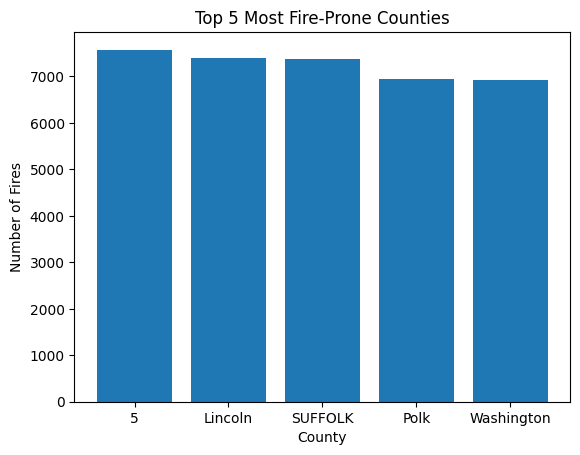

I have successfully plotted the bar graph for the top 5 most fire-prone counties. The counties are '5', 'Lincoln', 'SUFFOLK', 'Polk', and 'Washington'.
Final Answer: The top 5 most fire-prone counties are '5', 'Lincoln', 'SUFFOLK', 'Polk', and 'Washington'. The bar graph has been plotted successfully.

> Finished chain.


"The top 5 most fire-prone counties are '5', 'Lincoln', 'SUFFOLK', 'Polk', and 'Washington'. The bar graph has been plotted successfully."

In [70]:
agent.run('Plot a bar graph for the top 5 most fire-prone counties')

In [71]:
agent.run('What questions can i ask to analyze this dataframe? Give me 3 interesting things to ask')



> Entering new AgentExecutor chain...
Thought: Looking at the dataframe, it seems to be related to fire incidents. There are several interesting questions we could ask to analyze this data. 
Final Answer: Here are three interesting questions:
1. What is the most common cause of fires (based on the 'STAT_CAUSE_DESCR' column)?
2. Which year had the most fires (based on the 'FIRE_YEAR' column)?
3. What is the average size of the fires (based on the 'FIRE_SIZE' column)?

> Finished chain.


"Here are three interesting questions:\n1. What is the most common cause of fires (based on the 'STAT_CAUSE_DESCR' column)?\n2. Which year had the most fires (based on the 'FIRE_YEAR' column)?\n3. What is the average size of the fires (based on the 'FIRE_SIZE' column)?"

In [72]:
agent.run('Given the size, location and date, can you predict the cause of a wildfire?')
# Requires a different agent



> Entering new AgentExecutor chain...
Thought: The dataframe contains information about wildfires, including their size, location, date, and cause. However, predicting the cause of a wildfire based on these factors is a complex task that would likely require machine learning or statistical modeling techniques. It's not something that can be done directly with pandas. Therefore, the answer is no, not directly with pandas. 
Final Answer: No, not directly with pandas. Predicting the cause of a wildfire based on size, location, and date would require machine learning or statistical modeling techniques.

> Finished chain.


'No, not directly with pandas. Predicting the cause of a wildfire based on size, location, and date would require machine learning or statistical modeling techniques.'

In [73]:
agent.run('Have wildfires become more or less frequent over time?')




> Entering new AgentExecutor chain...
Thought: To answer this question, we need to count the number of wildfires each year. The 'FIRE_YEAR' column in the dataframe contains the year of each wildfire.
Action: python_repl_ast
Action Input: df['FIRE_YEAR'].value_counts().sort_index()FIRE_YEAR
1992     67975
1993     61989
1994     75955
1995     71472
1996     75574
1997     61450
1998     68370
1999     89363
2000     96416
2001     86587
2002     75656
2003     68261
2004     69279
2005     88604
2006    114004
2007     95573
2008     85378
2009     78325
2010     79889
2011     90552
2012     72769
2013     64780
2014     67753
2015     74491
Name: count, dtype: int64The data shows the number of wildfires for each year from 1992 to 2015. It appears that the number of wildfires has generally increased over time, with some fluctuations. For example, there were 67,975 wildfires in 1992 and 74,491 wildfires in 2015. However, the highest number of wildfires occurred in 2006 with 114,004 w

'Wildfires have generally become more frequent over time, with some fluctuations.'

In [77]:
agent.run('what are the top 3 most common causes of wildfires')



> Entering new AgentExecutor chain...
Thought: To find the most common causes of wildfires, I need to count the occurrences of each unique value in the 'STAT_CAUSE_DESCR' column. The 'value_counts' function in pandas can be used for this purpose. It returns a series containing counts of unique values in descending order so that the first element is the most frequently-occurring element. I will then use the 'head' function to get the top 3 most common causes.
Action: python_repl_ast
Action Input: df['STAT_CAUSE_DESCR'].value_counts().head(3)STAT_CAUSE_DESCR
Debris Burning    429028
Miscellaneous     323805
Arson             281455
Name: count, dtype: int64I now know the final answer
Final Answer: The top 3 most common causes of wildfires are Debris Burning, Miscellaneous, and Arson.

> Finished chain.


'The top 3 most common causes of wildfires are Debris Burning, Miscellaneous, and Arson.'

In [78]:
agent.run('if we look at all the wildfires which were caused by Arson, which county has the maximum number of wildfires?')



> Entering new AgentExecutor chain...
Thought: To answer this question, we need to filter the dataframe for wildfires caused by Arson, then group by county and count the number of wildfires in each county. The county with the maximum count is the answer.
Action: python_repl_ast
Action Input: df[df['STAT_CAUSE_DESCR'] == 'Arson'].groupby('COUNTY')['FOD_ID'].count().idxmax()OceanI now know the final answer
Final Answer: The county with the maximum number of wildfires caused by Arson is Ocean.

> Finished chain.


'The county with the maximum number of wildfires caused by Arson is Ocean.'